In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tensorflow import keras
from builtins import range, input
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
# from keras.applications import VGG19
# from keras.applications import ResNet50
# from keras.applications.inception_v3 import inception_v3
# from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
import cv2
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from sklearn.utils import shuffle
import os
from PIL import Image
import seaborn as sns

In [2]:
# def image_index(label, Y_train):
#     count = 3
#     value = 1
#     Y_list = list(Y_train)
#     for x in range(len(Y_train)):
#         if(Y_list[x] == label):
#             print(x)
#             save_x = x
#             count -= 1
#         if(count == 0):
#             return x
# t = image_index(9, Y)
# image = X[t]
# plt.imshow(image)

In [5]:
def create_dataset(img_folder):
    img_data_array = []
    for file in sorted(os.listdir(img_folder)):
        image_path = os.path.join(img_folder, file)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (40, 20))
        image = image.astype('float')
        image /= 255
        img_data_array.append(image)
    return np.array(img_data_array)

Text(0.5, 1.0, '3rd image')

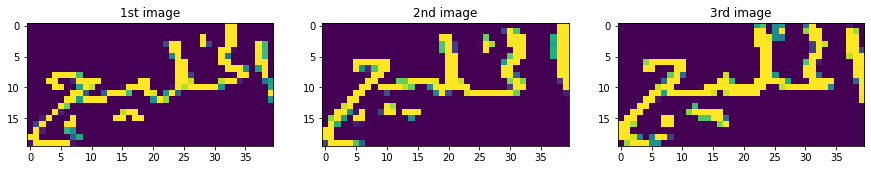

In [6]:
X = create_dataset("Images")

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
ax1.imshow(X[26])
ax1.set_title("1st image")
ax2.imshow(X[28])
ax2.set_title("2nd image")
ax3.imshow(X[30])
ax3.set_title("3rd image")

#  Data Augmentation

Text(0.5, 1.0, 'distorted image')

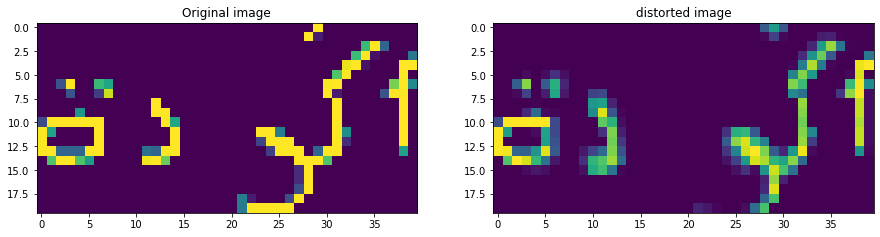

In [7]:
def distortion(img):
    import math
    (h, w) = img.shape
    scale_x = 1
    scale_y = 1
    center_x = w/2
    center_y = h/2
    radius = w/2
    amount = -0.5   # negative values produce pincushion
    amount = 0.5   # positive values produce barrel
    map_x = np.zeros((h, w), np.float32)
    map_y = np.zeros((h, w), np.float32)
    # create map with the barrel pincushion distortion formula
    for y in range(h):
        delta_y = scale_y * (y - center_y)
        for x in range(w):
            # determine if pixel is within an ellipse
            delta_x = scale_x * (x - center_x)
            distance = delta_x * delta_x + delta_y * delta_y
            if distance >= (radius * radius):
                map_x[y, x] = x
                map_y[y, x] = y
            else:
                factor = 1.0
                if distance > 0.0:
                    factor = math.pow(math.sin(math.pi * math.sqrt(distance) / radius / 2), amount)
                map_x[y, x] = factor * delta_x / scale_x + center_x
                map_y[y, x] = factor * delta_y / scale_y + center_y


    # do the remap
    dst = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return dst

test1 = distortion(X[50])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.imshow(X[50])
ax1.set_title("Original image")
ax2.imshow(test1)
ax2.set_title("distorted image")

Text(0.5, 1.0, 'dilaiton image')

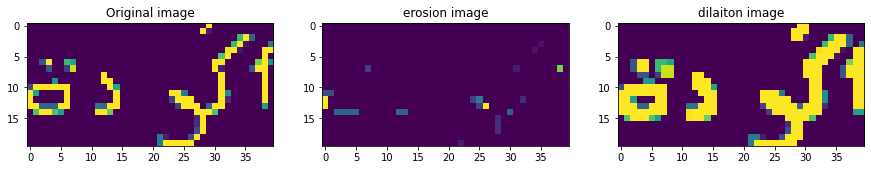

In [8]:
def erodilator(img):
    kernel = np.ones((2,2),np.int8)
    kernel_erode = np.ones((2,2),np.int8)
    erosion = cv2.erode(img,kernel_erode,iterations = 1)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    return erosion, dilation

erosion, dilation = erodilator(X[50])

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15, 5))
ax1.imshow(X[50])
ax1.set_title("Original image")
ax2.imshow(erosion)
ax2.set_title("erosion image")
ax3.imshow(dilation)
ax3.set_title("dilaiton image")

Text(0.5, 1.0, 'rotated image')

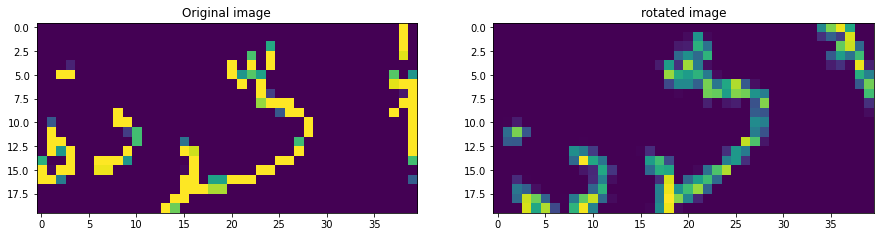

In [9]:
!pip install imutils
import imutils

def rotation(image):
    rot = imutils.rotate(image, angle=20)
    return rot

rot = rotation(X[4])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.imshow(X[4])
ax1.set_title("Original image")
ax2.imshow(rot)
ax2.set_title("rotated image")

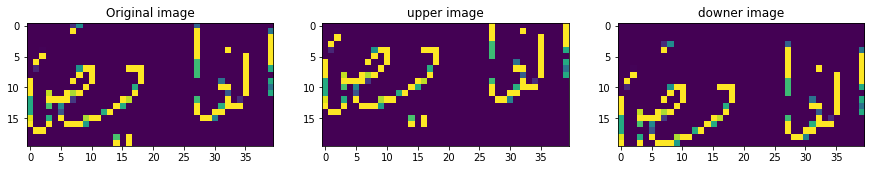

In [10]:
def shifter(image):
    tall, length = image.shape
    vect = int(tall/6)
    image_down = image[:tall-vect,:]
    empty_sp = np.zeros((vect,length))
    image_down = np.vstack((empty_sp, image_down))
    image1_up = image[vect:,:]
    image1_up = np.vstack((image1_up, empty_sp))
    return image1_up, image_down 

img1, img2 = shifter(X[5])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(X[5])
ax2.set_title("upper image")
ax2.imshow(img1)
ax3.set_title("downer image")
ax3.imshow(img2)

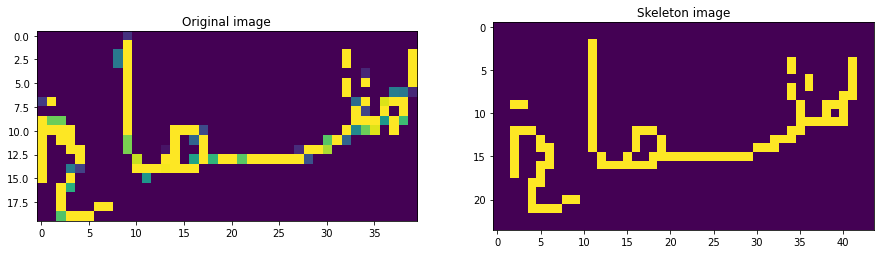

In [11]:
def getNeighbors(img, pixel):
    return img[pixel[0] - 1 : pixel[0] + 2 , pixel[1] - 1 : pixel[1] + 2]

def getNeighborsSum(neighbors):
    neighbors = np.ravel(neighbors)
    sum = 0
    for i in neighbors:
        if i != 0 :
            sum = sum + 1
    
    return sum - 1

def getTransitions(neighbors):
    sequence = [neighbors[0,1], neighbors[0, 2], neighbors[1, 2], neighbors[2, 2], neighbors[2, 1], neighbors[2, 0], neighbors[1, 0], neighbors[0,0], neighbors[0,1]]

    transitions = 0
    for i in range(len(sequence) - 1):
        if sequence[i] == 0 and sequence[i+1] == 1:
            transitions = transitions + 1
    
    return transitions

def skelly(img):
    img = np.pad(img, (2,2), mode="constant", constant_values=(0,0))
    img[img != 0] = 1
    while(True):
        marked = np.ones(img.shape, np.uint8)
        changed = False
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if img[i,j] == 0:
                    continue

                neighbors = getNeighbors(img, (i, j))
                if neighbors.shape != (3, 3):
                    continue
                
                sum = getNeighborsSum(neighbors)
                if not (sum <= 6 and sum >= 2):
                    continue 

                transitions = getTransitions(neighbors)
                if transitions != 1:
                    continue

                sequence = [neighbors[0,1], neighbors[0, 2], neighbors[1, 2], neighbors[2, 2], neighbors[2, 1], neighbors[2, 0], neighbors[1, 0], neighbors[0,0], neighbors[0,1]]
                neighbors2 = getNeighbors(img, (i-1, j))
                neighbors3 = getNeighbors(img, (i, j + 1))
                if sequence[0] * sequence[2] * sequence[6] != 0 and getTransitions(neighbors2) == 1 :
                    continue
                if sequence[0] * sequence[2] * sequence[4] != 0 and getTransitions(neighbors3) == 1:
                    continue

                changed = True
                marked[i,j] = 0

        img = np.multiply(img, marked)
        if not changed:
            return img

        
        
skeleton  = skelly(X[12])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.set_title("Original image")
ax1.imshow(X[12])
ax2.set_title("Skeleton image")
ax2.imshow(skeleton)

In [12]:
# def data_augmentation_image(image):
#     distorted_img =distortion(image)
#     erosion, dilation = erodilator(image)
#     image1_up, image_down = shifter(image)
#     rotated = rotation(image)

#     fig, axes = plt.subplots(2,3, figsize=(20, 10))
#     ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
#     ax1.set_title("rotated image")
#     ax1.imshow(rotated)
#     ax2.set_title("upper image")
#     ax2.imshow(image1_up)
#     ax3.set_title("downer image")
#     ax3.imshow(image_down)
#     ax4.set_title("eroted image")
#     ax4.imshow(erosion)
#     ax5.set_title("dialated image")
#     ax5.imshow(dilation)
#     ax6.set_title("distorted image")
#     ax6.imshow(distorted_img)
# data_augmentation_image(X[0])

In [13]:
def data_augmentation(X,Y):
    count = 1
    labels = []
    images = []
    for image,label in zip(X,Y):
        distorted_img =distortion(image)
        erosion, dilation = erodilator(image)
        image1_up, image_down = shifter(image)
        rotated = rotation(image)
        skeleton  = skelly(image)
        
        images.extend([distorted_img, erosion, dilation, image1_up, image_down, rotated, skeleton])
        labels.extend([label] * 7)

#         path = "Augmented_images/"
#         dist_name = str(count) + ".jpg"
#         erosion_name = str(count+1) + ".jpg"
#         dilation_name = str(count+2) + ".jpg"
#         image1_up_name = str(count+3) + ".jpg"
#         image_down_name = str(count+4) + ".jpg"
#         rotated_name = str(count+5) + ".jpg"

#         cv2.imwrite(path + dist_name, 255*distorted_img)
#         cv2.imwrite(path + erosion_name, 255*erosion)
#         cv2.imwrite(path + dilation_name, 255*dilation)
#         cv2.imwrite(path + image1_up_name, 255*image1_up)
#         cv2.imwrite(path + image_down_name, 255*image_down)
#         cv2.imwrite(path + rotated_name, 255*rotated)

#         count += 6
#     df.to_excel(path + "augmented.xlsx")
    df = pd.DataFrame(labels, columns=['Label'])
    return images, df

In [14]:
data = pd.read_excel("labels.xlsx", names=["Label"],header=None)
Y = data.Label
data.iloc[[26, 28, 30]]

,Label
26,2
28,2
30,2


In [15]:
!pip install arabic_reshaper
import arabic_reshaper

Arabic_words = []
Arabic_words.append("الرضّاع")
Arabic_words.append("الخليج")
Arabic_words.append("نقة")
Arabic_words.append("شعّال")
Arabic_words.append("مارث")
Arabic_words.append("الشمّاخ")
Arabic_words.append("زنّوش")
Arabic_words.append("الدخّانية")
Arabic_words.append("الفايض")
Arabic_words.append("أكّودة")
Arabic_words.append("سبعة آبار")
Arabic_words.append("سيدي ابراهيم الزهّار")
Arabic_words.append("المرناقية 20 مارس")
Arabic_words.append("شتاوة صحراوي")
Arabic_words.append("الفكّة")
Arabic_words.append("أوتيك")
Arabic_words.append("الفحص")
Arabic_words.append("الشرايع")
Arabic_words.append("حي الإنطلاقة")
Arabic_words.append("شواط")
Arabic_words.append("حي التضامن")



for word in range(len(Arabic_words)):
    Arabic_words[word] = arabic_reshaper.reshape(Arabic_words[word])
    Arabic_words[word] = Arabic_words[word][::-1]

labels = Arabic_words 

# sns.set_style('darkgrid')
# plt.figure(figsize=(7, 6))
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
# sns.countplot(ax=ax1, x= Y)
# ax1.set_title("Given distibution")
# sns.countplot(ax=ax2, x= Y)
# ax2.set_title("Labeled Dist")
# ax2.set_xticklabels(labels, rotation='vertical', fontsize=20)
# plt.show()



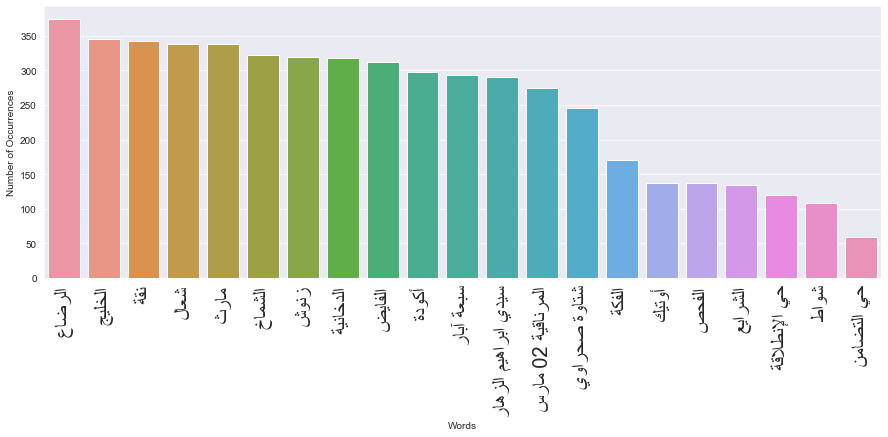

In [16]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
ax = sns.countplot(x= Y)
ax.set_xlabel('Words')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(labels, rotation='vertical', fontsize=20)
plt.show()

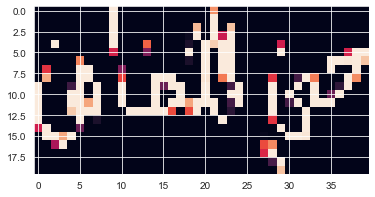

In [17]:
image = X[78]
plt.imshow(image)

In [18]:
images_augmented, df_augmented = data_augmentation(X,Y)

In [19]:
X_final = np.concatenate((X, images_augmented))
frames = [df, df_augmented]
data = pd.concat(frames)
Y_final = data.Label
X_final = np.expand_dims(X_final, axis=-1)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

In [20]:
Y_final.shape

NameError: name 'Y_final' is not defined

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size=0.1, random_state = 123)

NameError: name 'X_final' is not defined

<Figure size 504x432 with 0 Axes>

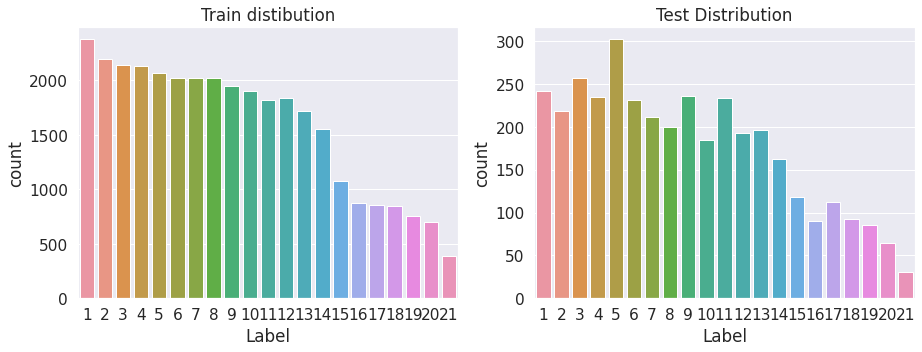

In [310]:
sns.set_style('darkgrid')
plt.figure(figsize=(7, 6))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(ax=ax1, x= Y_train)
ax1.set_title("Train distibution")
sns.countplot(ax=ax2, x= Y_test)
ax2.set_title("Test Distribution")
plt.show()

In [311]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Y_train_categories = label_encoder.fit_transform(Y_train)
label_encoder = preprocessing.LabelEncoder()
Y_test_categories = label_encoder.fit_transform(Y_test)

In [312]:
Y_train_categories = tf.keras.utils.to_categorical(Y_train_categories, 21)
Y_test_categories = tf.keras.utils.to_categorical(Y_test_categories, 21)

In [313]:
X_train.shape

(33257, 20, 40, 1)

In [340]:
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()
#Conv layer 1
#model.add(Conv2D(filters=30, kernel_size = (10, 10), padding = "same", strides=(1,2), input_shape=(20, 40, 1),activation='relu'))
#model.add(MaxPool2D(pool_size=(4, 4)))

#Conv layer 2
#model.add(Conv2D(filters=40, kernel_size = (6, 6), padding = "same", strides=(1,2),activation='relu'))
#model.add(MaxPool2D(pool_size=(4, 3)))

#Conv layer 3
#model.add(Conv2D(filters=20, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))

#Conv layer 4
#model.add(Conv2D(filters=20, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten layer
model.add(Conv2D(filters=20, kernel_size = (10, 10), padding = "same", strides=(1,2),  input_shape=(20, 40, 1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=10, kernel_size = (5, 5), padding = "same", strides=(1,2),  input_shape=(20, 40, 1),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Conv layer 2
#model.add(Conv2D(filters=20, kernel_size = (3, 3), padding = "same", strides=(1,2),activation='relu'))
#model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())

#Fully connected layers
model.add(Dense(units = 256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(units = 21, activation='softmax'))

model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 20, 20, 20)        2020      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 10, 10, 20)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 10, 5, 10)         5010      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 5, 2, 10)          0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 256)               25856     
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)             

In [341]:
epochs = 100
batch_size = 32

In [342]:
#Training
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [343]:
from keras.callbacks import EarlyStopping
history = model.fit(X_train,
                    Y_train_categories,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs,
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
                    verbose=1)

Epoch 1/100
832/832 [==============================] - 4s 4ms/step - loss: 2.0763 - accuracy: 0.4539 - val_loss: 1.4276 - val_accuracy: 0.6911
Epoch 2/100
832/832 [==============================] - 3s 4ms/step - loss: 1.4193 - accuracy: 0.7030 - val_loss: 1.2254 - val_accuracy: 0.7462
Epoch 3/100
832/832 [==============================] - 3s 4ms/step - loss: 1.2714 - accuracy: 0.7453 - val_loss: 1.1355 - val_accuracy: 0.7760
Epoch 4/100
832/832 [==============================] - 4s 4ms/step - loss: 1.1806 - accuracy: 0.7642 - val_loss: 1.1022 - val_accuracy: 0.7814
Epoch 5/100
832/832 [==============================] - 3s 4ms/step - loss: 1.1300 - accuracy: 0.7733 - val_loss: 1.0569 - val_accuracy: 0.7903
Epoch 6/100
832/832 [==============================] - 3s 4ms/step - loss: 1.0818 - accuracy: 0.7821 - val_loss: 1.0315 - val_accuracy: 0.7903
Epoch 7/100
832/832 [==============================] - 3s 4ms/step - loss: 1.0424 - accuracy: 0.7867 - val_loss: 1.0515 - val_accuracy: 0.7880

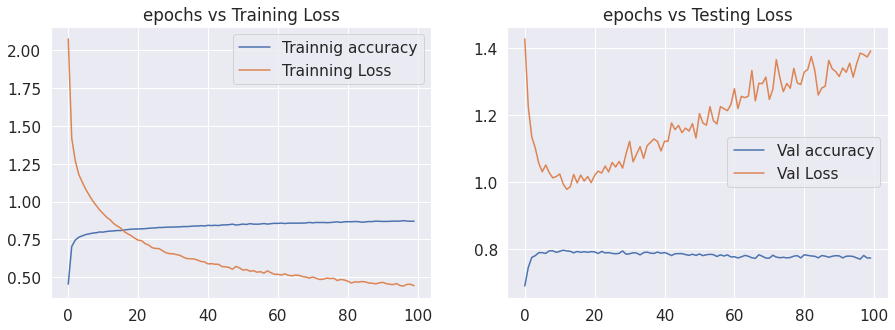

In [344]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

count = range(len(train_accuracy))
ax1.plot(count, train_accuracy, label='Trainnig accuracy')
ax1.plot(count, train_loss, label='Trainning Loss')
ax1.set_title('epochs vs Training Loss')
ax1.legend()

train_accuracy = history.history['val_accuracy']
train_loss = history.history['val_loss']

count = range(len(train_accuracy))
ax2.plot(count, train_accuracy, label='Val accuracy')
ax2.plot(count, train_loss, label='Val Loss')
ax2.set_title('epochs vs Testing Loss')
ax2.legend()

In [361]:
###Check_point
from IPython.display import FileLink
model.save("/kaggle/working/Reworked_model.h5")
#Load_checkpoint
#model=load_model('Normal (no augment).h5')

In [362]:
import os
os.chdir(r'/kaggle/working')
FileLink('Reworked_model.h5')

/kaggle/working/Reworked_model.h5

In [3]:
from tensorflow.keras.models import load_model
classifierV1=load_model('Reworked_model.h5')
classifierV1.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 20, 20, 20)        2020      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 10, 10, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 10, 5, 10)         5010      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 5, 2, 10)         0         
 g2D)                                                            
                                                                 
 flatten_41 (Flatten)        (None, 100)               0         
                                                                 
 dense_122 (Dense)           (None, 256)             

In [4]:
label_encoder = preprocessing.LabelEncoder()
Y_categories = label_encoder.fit_transform(Y)
Y_categories = tf.keras.utils.to_categorical(Y_categories, 21)
score = model.evaluate(np.expand_dims(X, axis=-1), Y_categories, verbose=0)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

NameError: name 'preprocessing' is not defined

In [346]:
score = model.evaluate(X_test, Y_test_categories, verbose=0)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

Test set
  Loss: 1.40
  Accuracy: 0.78


In [376]:
predicted_classes

array([14, 13, 11, ..., 14, 11,  0])

In [347]:
!pip install arabic_reshaper
import arabic_reshaper

Y_pred = model.predict(X_test)
predicted_classes = np.argmax(Y_pred, axis=1)
expected_classes = np.argmax(Y_test_categories, axis=1)

Arabic_words = []
Arabic_words.append("الرضّاع")
Arabic_words.append("الخليج")
Arabic_words.append("نقة")
Arabic_words.append("شعّال")
Arabic_words.append("مارث")
Arabic_words.append("الشمّاخ")
Arabic_words.append("زنّوش")
Arabic_words.append("الدخّانية")
Arabic_words.append("الفايض")
Arabic_words.append("أكّودة")
Arabic_words.append("سبعة آبار")
Arabic_words.append("سيدي ابراهيم الزهّار")
Arabic_words.append("المرناقية 20 مارس")
Arabic_words.append("شتاوة صحراوي")
Arabic_words.append("الفكّة")
Arabic_words.append("أوتيك")
Arabic_words.append("الفحص")
Arabic_words.append("الشرايع")
Arabic_words.append("حي الإنطلاقة")
Arabic_words.append("شواط")
Arabic_words.append("حي التضامن")



for word in range(len(Arabic_words)):
    Arabic_words[word] = arabic_reshaper.reshape(Arabic_words[word])
    Arabic_words[word] = Arabic_words[word][::-1]

labels = Arabic_words 

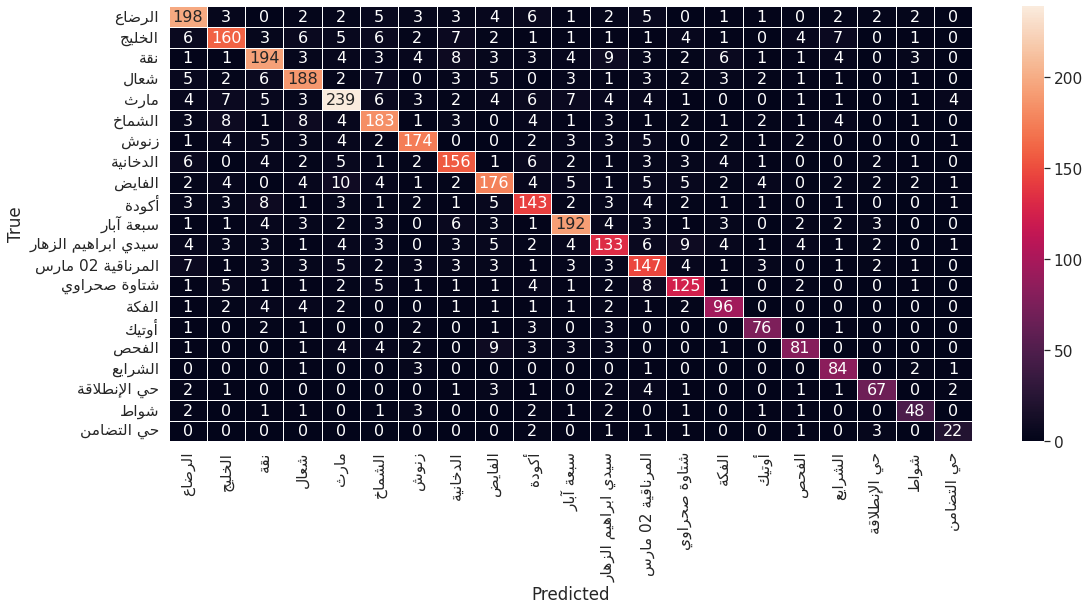

In [348]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

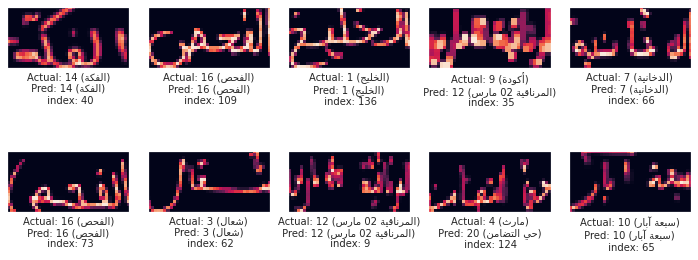

In [377]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    
    img_index = np.random.randint(0, 150)
    plt.imshow(X_test[img_index], cmap=plt.cm.gray)
    actual_label  = np.argmax(Y_test_categories[img_index])
    predicted_label = predicted_classes[img_index]

    plt.xlabel("Actual: {} ({})\n Pred: {} ({}) \n index: {}".format(
        actual_label, labels[actual_label], predicted_label, labels[predicted_label], img_index
    ), fontsize=10)
    
plt.tight_layout()
plt.show()

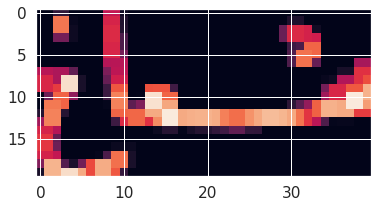

In [372]:
plt.imshow(X_test[61]*255)